# 0. Install and Import Dependencies

In [ ]:
%pip list

In [2]:
%pip install opencv-python matplotlib imageio gdown tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt


In [4]:
import imageio

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [7]:
import gdown

In [8]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=9e2a5473-ca25-45c5-85e4-f84b1c6bb422
To: c:\Users\KIIT\OneDrive\Desktop\python\LIP_READING\data.zip
100%|██████████| 423M/423M [00:28<00:00, 14.7MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [9]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)                        # read frames of the video
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()                         # ret-wheather frame is captured or not  , frame actual matrix representation of captured frame
        frame = tf.image.rgb_to_grayscale(frame)        # convert to grayscale
        frames.append(frame[190:236,80:220,:])          # Crop only mouth region and add pixel matrix to frame list
    cap.release()
    
    mean = tf.math.reduce_mean(frames )
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std   # standarrdize pixel values and make it float16 to reduce furthur computation times

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
# encode vocabs to its index and set every character that is not in vocab to empty strig 
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# decode do the opposite of above 
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [12]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [13]:
char_to_num(['o', 'm', 'm'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([15, 13, 13], dtype=int64)>

In [14]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [15]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    # in every line there are 3 elemnts
    # 1st and 2nd are the time stamps during which word is said
    # 3rd is actual word that is said
    for line in lines:
        line = line.split()
        if line[2] != 'sil':                     # dont consider silence
            tokens = [*tokens,' ',line[2]] 
    # all encoded words are stored in tokens list so return their concatination to train model
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [16]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('maindata','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('maindata','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [17]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [18]:
#test_path = bytes.decode(test_path.numpy())

In [19]:
hi = tf.convert_to_tensor(test_path).numpy().decode('utf-8')
hi

'.\\data\\s1\\bbal6n.mpg'

In [20]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

''

In [21]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [22]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

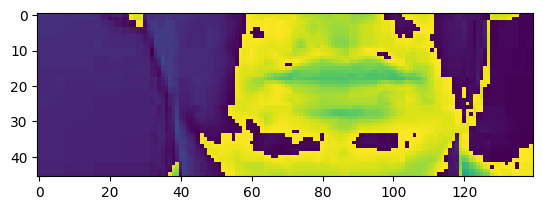

In [23]:
plt.imshow(frames[0])

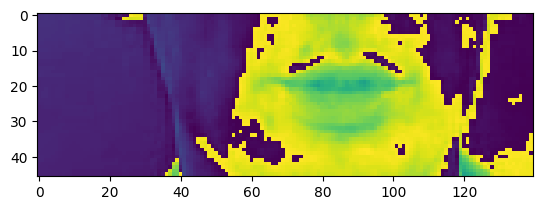

In [24]:
plt.imshow(frames[23])

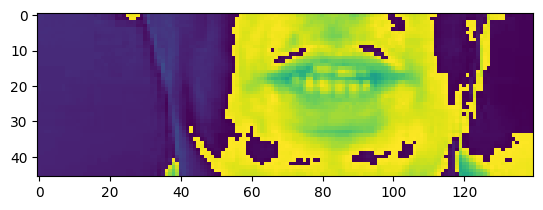

In [25]:
plt.imshow(frames[40])

In [26]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [27]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [28]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [29]:
from matplotlib import pyplot as plt

In [30]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)


In [31]:
# Train - Test Split
train = data.take(450)
test = data.skip(450)

In [32]:
len(train)

450

In [33]:
frames, alignments = data.as_numpy_iterator().next()

In [34]:
len(frames)

2

In [35]:
sample = data.as_numpy_iterator()

In [36]:
val = sample.next()
val[0]

array([[[[[1.4033439 ],
          [1.4033439 ],
          [1.4393271 ],
          ...,
          [0.35983178],
          [0.35983178],
          [0.35983178]],

         [[1.4033439 ],
          [1.4033439 ],
          [1.4393271 ],
          ...,
          [0.35983178],
          [0.35983178],
          [0.35983178]],

         [[1.4033439 ],
          [1.4033439 ],
          [1.3673607 ],
          ...,
          [0.35983178],
          [0.35983178],
          [0.35983178]],

         ...,

         [[1.0435121 ],
          [1.0435121 ],
          [1.007529  ],
          ...,
          [0.03598318],
          [0.03598318],
          [0.        ]],

         [[1.0435121 ],
          [1.0435121 ],
          [1.007529  ],
          ...,
          [0.07196636],
          [0.        ],
          [0.        ]],

         [[1.0435121 ],
          [1.0435121 ],
          [1.007529  ],
          ...,
          [0.03598318],
          [0.        ],
          [9.175711  ]]],


        [[[1.5112

In [37]:
val[0].shape

(2, 75, 46, 140, 1)

In [38]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)

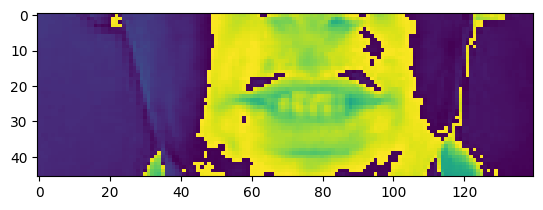

In [39]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][23])

In [40]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place white in j two now'>

# 3. Design the Deep Neural Network

In [41]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [42]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [43]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [45]:
5*17*75

6375

In [46]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [47]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'55ggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggngu'>

In [48]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'55ggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggngu'>

In [49]:
model.input_shape

(None, 75, 46, 140, 1)

In [50]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [51]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [52]:
# define our special CTC loss function
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [53]:
# produce example original lable and predicted lable after each epoch to see model performance
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
#         if epoh == 1 or epoch % 4 == 0:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('-'*100)

In [54]:
# use adam optimizer
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [55]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [56]:
schedule_callback = LearningRateScheduler(scheduler)

In [57]:
example_callback = ProduceExample(test)

In [ ]:
history = model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

 64/450 [===>..........................] - ETA: 4:07:55 - loss: 116.8402

In [ ]:
# history

In [ ]:
training_loss = [85.2746 ,70.9716 ,66.9147 ,63.9592 ,61.8173 ,60.1350 ,58.5690 ,55.7670 ,52.7824 ,50.8946 ,49.0681 ,47.0584 ,44.3900 ,42.5115 ,39.7808 ,37.8971 ,35.7804 ,33.3151 ,30.8727 ,28.5955 ,26.3424 ,24.4883 ,22.5235 ,20.8805 ,19.3281 ,17.7996 ,16.5271 ,15.0045 ,14.0592,13.1728 ,12.3935 ,11.1808 ,10.4560 ,9.8701 ,9.0793 ,8.4954 ,8.0987 ,7.6377 ,7.3532 ,6.9693 ,6.5354 ,6.3091 ,6.1269 ,5.8158 ,5.5908 ,5.5060 ,5.3135 ,5.0879 ,5.0412 ,4.9653 ]
validation_loss = [69.1930 ,65.6452 ,62.2782 ,63.9592 ,58.2501 ,55.6897 ,55.3017 ,50.9557 ,48.8146 ,46.5846 ,45.2084 ,41.4461 ,40.2157 ,36.6420 ,34.9563 ,31.5592 ,35.7804 ,27.6424 ,26.3044 ,23.0497 ,20.3814 ,18.4825 ,17.3327 ,15.4639 ,15.1650 ,12.4896 ,11.0701 ,10.2751 ,9.1001 ,9.4078 ,8.2575 ,7.8103 ,6.9572 ,6.6227 ,5.7344 ,4.9208 ,5.0810 ,4.6688 ,4.1540 ,3.7644 ,3.7980 ,3.4402 ,3.5841 ,2.9137 ,3.5077 ,2.7765 ,2.7981 ,2.4640 ,2.2985 ,2.2633 ]

In [ ]:

# Plot the loss
plt.figure()
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('./models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
final_loss = model.evaluate(test)
print(f"\n🔍 Final CTC Loss on Test Set: {final_loss:.4f}")


In [ ]:
from jiwer import wer  # For word error rate (install with: pip install jiwer)

test_data = test.as_numpy_iterator()

total_chars = 0
correct_chars = 0
predictions = []
actuals = []

for batch in test:
    X, y = batch
    yhat = model.predict(X)
    
    # Decode predictions
    decoded_preds = tf.keras.backend.ctc_decode(yhat, input_length=[yhat.shape[1]] * yhat.shape[0], greedy=True)[0][0]

    for i in range(len(decoded_preds)):
        pred_text = tf.strings.reduce_join(num_to_char(decoded_preds[i])).numpy().decode('utf-8').replace('[UNK]', '')
        true_text = tf.strings.reduce_join(num_to_char(y[i])).numpy().decode('utf-8').replace('[UNK]', '')

        predictions.append(pred_text)
        actuals.append(true_text)

        # Character-level accuracy
        min_len = min(len(pred_text), len(true_text))
        correct_chars += sum([pred_text[j] == true_text[j] for j in range(min_len)])
        total_chars += len(true_text)

# Final Character Accuracy
char_accuracy = correct_chars / total_chars * 100
print(f"✅ Final Character Accuracy: {char_accuracy:.2f}%")

# Optional: Word Error Rate (WER)
print(f"📉 Word Error Rate (WER): {wer(actuals, predictions):.4f}")


In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1JAmcd2v0JcZStgs69VytgqwGJMlhNeaT&export=download'
output = 'check.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('check.zip', 'models')

In [ ]:
model.load_weights('models\models\checkpoint')

In [ ]:
final_loss = model.evaluate(test)
print(f"\n🔍 Final CTC Loss on Test Set: {final_loss:.4f}")



In [ ]:
from jiwer import wer  # For word error rate (install with: pip install jiwer)

test_data = test.as_numpy_iterator()

total_chars = 0
correct_chars = 0
predictions = []
actuals = []

for batch in test:
    X, y = batch
    yhat = model.predict(X)
    
    # Decode predictions
    decoded_preds = tf.keras.backend.ctc_decode(yhat, input_length=[yhat.shape[1]] * yhat.shape[0], greedy=True)[0][0]

    for i in range(len(decoded_preds)):
        pred_text = tf.strings.reduce_join(num_to_char(decoded_preds[i])).numpy().decode('utf-8').replace('[UNK]', '')
        true_text = tf.strings.reduce_join(num_to_char(y[i])).numpy().decode('utf-8').replace('[UNK]', '')

        predictions.append(pred_text)
        actuals.append(true_text)

        # Character-level accuracy
        min_len = min(len(pred_text), len(true_text))
        correct_chars += sum([pred_text[j] == true_text[j] for j in range(min_len)])
        total_chars += len(true_text)

# Final Character Accuracy
char_accuracy = correct_chars / total_chars * 100
print(f"✅ Final Character Accuracy: {char_accuracy:.2f}%")

# Optional: Word Error Rate (WER)
print(f"📉 Word Error Rate (WER): {wer(actuals, predictions):.4f}")


In [ ]:
sample = test_data.next()

In [ ]:
sample[0].shape

In [ ]:
sample[1].shape

In [ ]:
sample[1]

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('-'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('-'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [ ]:
print('-'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('-'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]